**DATA EXPLORATION**

In [1]:
import pandas as pd

data=pd.read_csv("/content/HR_comma_sep.csv")
print(data.info())
print(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None
       satisfaction_level  last_evaluation  ...  Department  salary
0                    0.38             0.53  ...       sales     low
1                    0.80             0.86  ...       sales  med

Only department and salaries have the type object. It is recommended to convert these to numbers as it would make applying the ML algorithm easier.

In [2]:
#changing the datatype of salaries to category
data["salary"]=data["salary"].astype('category')
#re ordering salaries
data["salary"] = data["salary"].cat.reorder_categories(['low', 'medium', 'high'])
# Remapping categories with integer values
data["salary"] = data["salary"].cat.codes



In [5]:
print(data["salary"])

0        0
1        1
2        1
3        0
4        0
        ..
14994    0
14995    0
14996    0
14997    0
14998    0
Name: salary, Length: 14999, dtype: category
Categories (3, int64): [0, 1, 2]


In [3]:
# Getting dummies and save them inside a new DataFrame
departments = pd.get_dummies(data["Department"])
#Dropping technical to avoid dummy trap
departments = departments.drop("technical", axis = 1)
# Dropping the old column "department" as you don't need it anymore
data = data.drop("Department", axis=1)
# Joining the new dataframe "departments" to your employee dataset: done
data = data.join(departments)
print(departments)

       IT  RandD  accounting  hr  ...  marketing  product_mng  sales  support
0       0      0           0   0  ...          0            0      1        0
1       0      0           0   0  ...          0            0      1        0
2       0      0           0   0  ...          0            0      1        0
3       0      0           0   0  ...          0            0      1        0
4       0      0           0   0  ...          0            0      1        0
...    ..    ...         ...  ..  ...        ...          ...    ...      ...
14994   0      0           0   0  ...          0            0      0        1
14995   0      0           0   0  ...          0            0      0        1
14996   0      0           0   0  ...          0            0      0        1
14997   0      0           0   0  ...          0            0      0        1
14998   0      0           0   0  ...          0            0      0        1

[14999 rows x 9 columns]


In [10]:
print(data["Department"].value_counts())

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: Department, dtype: int64


In [4]:
data.rename(columns = {'left':'churn'}, inplace = True)
employees_total = len(data)
# Printing the number of employees who left/stayed
print(data["churn"].value_counts())
# Printing the percentage of employees who left/stayed
print(data["churn"].value_counts()/employees_total*100)

0    11428
1     3571
Name: churn, dtype: int64
0    76.191746
1    23.808254
Name: churn, dtype: float64


It is visible from the dataset that 76% of the employees stayed while 23% left (churned). However this seems like an uneven distribution of results which I will address later.

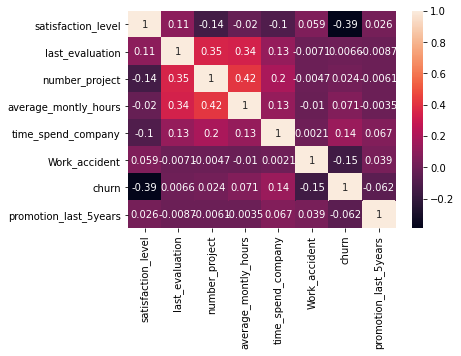

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
corr_matrix = data.corr()
sns.heatmap(corr_matrix,annot=True)
plt.show()

**OBSERVATION:** It is visible from that following heatmap that churn has a very strong negative correlation with the satisfaction_level and the strongest positive correlation with the time spent in the company.

**PREDICTIONS**

In [20]:
pip install sklearn

In [5]:
import sklearn as sk
from sklearn.model_selection import train_test_split

# Choose the dependent variable column (churn) and set it as target
target = data['churn']

# Drop column churn and set everything else as features
features = data.drop("churn",axis=1)
target_train, target_test, features_train, features_test = train_test_split(target,features,test_size=0.25)

In [6]:
import pandas as pd
import pydotplus #pip install pydotplus
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
import numpy as np

Using decision Trees can also quantify the effect of the different features on the target. Here, it can tell you which features have the strongest and weakest impacts on the decision to leave the company which I will demonstrate later in this workbook.

In [9]:
model = DecisionTreeClassifier(random_state=42)
model.fit(features_train,target_train)
model.score(features_test,target_test)*100


97.81333333333333

So on the testing set, the algorithm can accurately predict if the employee would leave or not 97.33% of the time.

In [10]:
export_graphviz(model,"tree.dot")

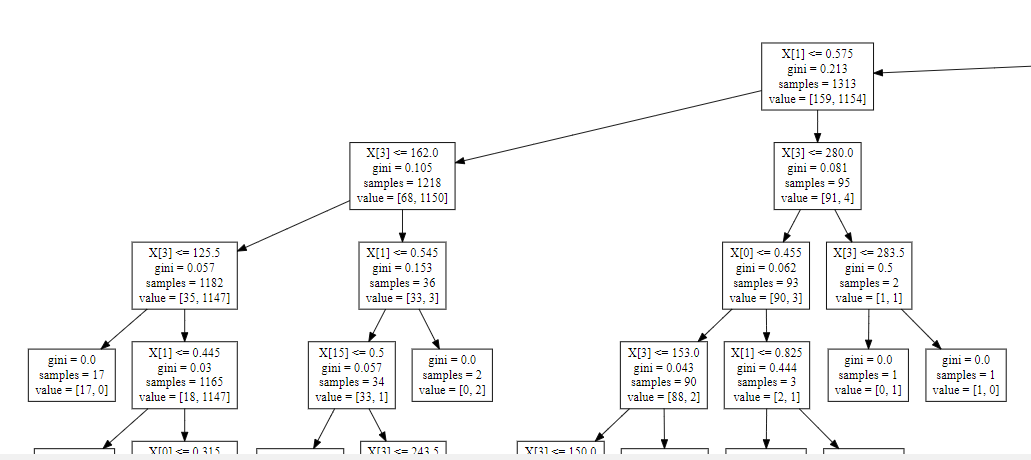

My decision tree looks something like this. Decreasing gini down the tree shows that the objective is achieved.

In [12]:
model.score(features_train,target_train)*100

100.0

**TUNING**

100% accuracy on the training data and 97% on the test data shows that the model is overfitting. So time to tune the classfier.

In [14]:
model_depth_5 = DecisionTreeClassifier(max_depth=5, random_state=42)
# Fit the model
model_depth_5.fit(features_train,target_train)

# Print the accuracy of the prediction for the training set
print(model_depth_5.score(features_train,target_train)*100)

# Print the accuracy of the prediction for the test set
print(model_depth_5.score(features_test,target_test)*100)

97.55533825228909
97.57333333333334


Limiting the depth of the decision tree to reduce overfitting has worked as both the training and test data are now 97% accurate.

In [15]:
model_depth_6 = DecisionTreeClassifier(max_depth=6, random_state=42)
# Fit the model
model_depth_6.fit(features_train,target_train)

# Print the accuracy of the prediction for the training set
print(model_depth_6.score(features_train,target_train)*100)

# Print the accuracy of the prediction for the test set
print(model_depth_6.score(features_test,target_test)*100)

97.86647702017957
97.81333333333333


Better results with depth as 6.

In [26]:
model_depth_7 = DecisionTreeClassifier(max_depth=7, random_state=42)
# Fit the model
model_depth_7.fit(features_train,target_train)

# Print the accuracy of the prediction for the training set
print(model_depth_7.score(features_train,target_train)*100)

# Print the accuracy of the prediction for the test set
print(model_depth_7.score(features_test,target_test)*100)

98.11538803449196
97.81333333333333


Best results with depth 7.

In [16]:
# Initializing the DecisionTreeClassifier while limiting the sample size in leaves to 100
model_sample_100 = DecisionTreeClassifier(min_samples_leaf=100, random_state=42)

# Fitting the model
model_sample_100.fit(features_train,target_train)

# Printing the accuracy of the prediction (in percentage points) for the training set
print(model_sample_100.score(features_train,target_train)*100)

# Printing the accuracy of the prediction (in percentage points) for the test set
print(model_sample_100.score(features_test,target_test)*100)

96.49746644146147
96.48


Comparitvely ower accuracies with this. But only accuracies are not enough. Time to try some more metrics.

In [17]:
# Import the function to calculate precision score
from sklearn.metrics import precision_score

# Predict whether employees will churn using the test set
prediction = model.predict(features_test)

# Calculate precision score by comparing target_test with the prediction
precision_score(target_test, prediction)

0.9360780065005417

93% of the churn predictions of the orignial model were correct.

In [28]:
# Import the function to calculate precision score
from sklearn.metrics import precision_score

# Predict whether employees will churn using the test set
prediction = model_depth_6.predict(features_test)

# Calculate precision score by comparing target_test with the prediction
precision_score(target_test, prediction)

0.9797377830750894

97.9% of the churn predictions of the tuned model (with depth=6) were correct.

In [19]:
# Import the function to calculate ROC/AUC score
from sklearn.metrics import roc_auc_score

# Use initial model to predict churn (based on features_test)
prediction = model.predict(features_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(target_test, prediction)

0.9767310722151494

97.6% of the churn predictions about both stayers and leavers on the original model were correct.

In [35]:
# Import the function to calculate ROC/AUC score
from sklearn.metrics import roc_auc_score

# Use initial model to predict churn (based on features_test)
prediction = model_depth_6.predict(features_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(target_test, prediction)

0.9603907255065112

In [31]:
# Import the function to calculate ROC/AUC score
from sklearn.metrics import roc_auc_score

# Use initial model to predict churn (based on features_test)
prediction = model_depth_7.predict(features_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(target_test, prediction)

0.9627250607506022

96.2% of the churn predictions about both stayers and leavers on the tuned model were correct. Now to address the class imbalance b/w the training and test sets as discussed earlier.

In [23]:
# Initialize the DecisionTreeClassifier 
model_depth_6_b = DecisionTreeClassifier(max_depth=6,class_weight="balanced",random_state=42)

# Fit the model
model_depth_6_b.fit(features_train,target_train)

# Print the accuracy of the prediction (in percentage points) for the test set
print(model_depth_6_b.score(features_test,target_test)*100)

93.94666666666667


In [24]:
# Initialize the DecisionTreeClassifier 
model_depth_5_b = DecisionTreeClassifier(max_depth=5,class_weight="balanced",random_state=42)

# Fit the model
model_depth_5_b.fit(features_train,target_train)

# Print the accuracy of the prediction (in percentage points) for the test set
print(model_depth_5_b.score(features_test,target_test)*100)

94.50666666666667


In [25]:
# Initialize the DecisionTreeClassifier 
model_depth_7_b = DecisionTreeClassifier(max_depth=7,class_weight="balanced",random_state=42)

# Fit the model
model_depth_7_b.fit(features_train,target_train)

# Print the accuracy of the prediction (in percentage points) for the test set
print(model_depth_7_b.score(features_test,target_test)*100)

97.28


Note that the general accuracy is lower for all these three models after class balance but let's try with AOC score to get a more holistic understanding of the results.

In [34]:
# Import the function to calculate ROC/AUC score
from sklearn.metrics import roc_auc_score

# Use initial model to predict churn (based on features_test)
prediction = model_depth_6_b.predict(features_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(target_test, prediction)

0.944794034686615

In [33]:
# Import the function to calculate ROC/AUC score
from sklearn.metrics import roc_auc_score

# Use initial model to predict churn (based on features_test)
prediction = model_depth_7_b.predict(features_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(target_test, prediction)

0.9615665563160346

**HYPERPARAMTER TUNING**

In [36]:
# Generate values for maximum depth
depth = [i for i in range(5,21,1)]

# Generate values for minimum sample size
samples = [i for i in range(50,500,50)]

# Create the dictionary with parameters to be checked
parameters = dict(max_depth=depth, min_samples_leaf=samples)

# import the GridSearchCV function
from sklearn.model_selection import GridSearchCV

# set up parameters: done
parameters = dict(max_depth=depth, min_samples_leaf=samples)

# initialize the param_search function using the GridSearchCV function, initial model and parameters above
param_search = GridSearchCV(model, parameters)

# fit the param_search to the training dataset
param_search.fit(features_train, target_train)

# print the best parameters found
print(param_search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 50}


Using GridSearch to get the best combo for prediction results.

In [37]:
# Import the function for implementing cross validation
from sklearn.model_selection import cross_val_score

# Use that function to print the cross validation score for 10 folds
print(cross_val_score(model,features,target,cv=10))

[0.98466667 0.988      0.97066667 0.964      0.956      0.982
 0.988      0.99133333 1.         1.        ]


Using k-fold cross validation to get the best combo for prediction results.

Now to train the **best model** based on the observations.

In [39]:
model_best = DecisionTreeClassifier(max_depth=5,min_samples_leaf=50, random_state=42)
# Fit the model
model_best.fit(features_train,target_train)

# Print the accuracy of the prediction for the training set
print(model_best.score(features_train,target_train)*100)

# Print the accuracy of the prediction for the test set
print(model_best.score(features_test,target_test)*100)

96.86194328384745
96.93333333333334


In [40]:
# Import the function to calculate ROC/AUC score
from sklearn.metrics import roc_auc_score

# Use initial model to predict churn (based on features_test)
prediction = model_best.predict(features_test)

# Calculate ROC/AUC score by comparing target_test with the prediction
roc_auc_score(target_test, prediction)

0.9515150930446025

In [41]:
# Calculate feature importances
feature_importances = model_best.feature_importances_

# Create a list of features
feature_list = list(features)

# Save the results inside a DataFrame using feature_list as an index
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False)

,importance
satisfaction_level,0.549965
time_spend_company,0.183034
last_evaluation,0.135577
number_project,0.097179
average_montly_hours,0.033726
accounting,0.000520
hr,0.000000
sales,0.000000
product_mng,0.000000
marketing,0.000000


So as I pointed out in the correlation matrix at the start of the project,satisfaction level and time spent at the company really are the most important features when it comes to predicting churn. Now to drop unnecessary features. 

In [42]:
# select only features with relative importance higher than 1%
selected_features = relative_importances[relative_importances.importance>0.01]

# create a list from those features: done
selected_list = selected_features.index

# transform both features_train and features_test components to include only selected features
features_train_selected = features_train[selected_list]
features_test_selected = features_test[selected_list]

In [48]:
# Initializing the best model after dropping the features
model_bestt = DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, class_weight="balanced", random_state=42)

# Fit the model using only selected features from training set: done
model_bestt.fit(features_train_selected, target_train)

# Make prediction based on selected list of features from test set
prediction_best = model_bestt.predict(features_test_selected)

# Print the general accuracy of the model_best
print(model_bestt.score(features_test_selected, target_test) * 100)

# Print the ROC/AUC score of the model predictions
print(roc_auc_score(target_test, prediction_best) * 100)

94.39999999999999
94.1927110303247


So these are the scores of the best possible model by keeping all the necessary features.